<a href="https://colab.research.google.com/github/julienjaber/Semantic-segmentation-masks/blob/main/Semantic_Segmentation_JJvF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
!pip install opencv-python-headless==4.1.2.30
import cv2
import glob
import numpy as np
import re
import os
import torch
from torchvision import models
from IPython.display import Image
import shutil
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms as transforms

!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.8 MB 1.3 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.6.0.66
    Uninstalling opencv-python-headless-4.6.0.66:
      Successfully uninstalled opencv-python-headless-4.6.0.66


In [ ]:
# connect to google drive
drive.mount('/content/gdrive')

#drive.flush_and_unmount()

Mounted at /content/gdrive


In [ ]:
!unzip -u '/content/gdrive/MyDrive/Colab Notebooks/thumbnails_dataset.zip' -d "/content/gdrive/MyDrive/Datasets2/"

In [ ]:
"""transform = T.Compose([T.Resize(256),
                 T.CenterCrop(224),
                 T.ToTensor(), 
                 T.Normalize(mean = [0.485, 0.456, 0.406], 
                             std = [0.229, 0.224, 0.225])])
"""

In [ ]:
class MaskedThumbnailDataset(Dataset):
    def __init__(self, split, data_root, image_size, preprocessing = None, transform=None) -> None:
        self.split = split
        self.transform = transform
        self.image_size = image_size
        self.preprocessing = preprocessing

        self.orig_image_names = []
        self.surgical_image_names = []
        self.transform = transform

        for inner_dir in sorted(os.listdir(data_root)):
            if "_masked" in inner_dir or "DS_Store" in inner_dir:
                continue
            for original_image_name in sorted(os.listdir(os.path.join(data_root, inner_dir))):
                if ".png" in original_image_name or ".jpg" in original_image_name or ".JPG" in original_image_name or ".jpeg" in original_image_name:
                    
                    mask_path = os.path.join(data_root, "_masked")

                    dot = original_image_name.index(".")
                    orig_path = os.path.join(data_root, inner_dir, original_image_name)
                    surg_path = os.path.join(mask_path, inner_dir, original_image_name[:dot] + "_surgical" + original_image_name[dot:])
                    if os.path.exists(orig_path) and os.path.exists(surg_path):
                        self.orig_image_names.append(orig_path)
                        self.surgical_image_names.append(surg_path)


        
    def __len__(self):
        return len(self.orig_image_names)

    def __getitem__(self, index):
        image_path = self.orig_image_names[index]
        seg_mask_path = self.surgical_image_names[index]

        label = Image.open(image_path).convert('RGB')
        label = self.transform(label)[:3, :, :]

        image = Image.open(seg_mask_path).convert('RGB')
        image = self.transform(image)[:3, :, :]

        label = torch.where(image != label, 1, 0)
        # reduce number of channels from 3 to 1
        label = torch.amax(label, 0)
        label = torch.unsqueeze(label, 0)


        
        if self.preprocessing:
          sample = self.preprocessing(image=image, mask=label)
          image, label = sample['image'], sample['label']

        return image, label

In [ ]:
mean = torch.Tensor([0.5283, 0.4574, 0.4191])
std = torch.Tensor([0.2944, 0.2761, 0.2739])
img_len = 128
image_size = (img_len,img_len)

transform=transforms.Compose([
                               transforms.Resize(image_size[0]),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std),
                           ])
                           

data_root = "/content/gdrive/MyDrive/Datasets2/thumbs_unmasked/thumbnails128x128"
dataset = MaskedThumbnailDataset(split="all", data_root=data_root, image_size=image_size, transform=transform)

In [ ]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    verbose=True,
)

In [ ]:
# https://discuss.pytorch.org/t/issues-with-torch-utils-data-random-split/22298
train_length=int(0.7* len(dataset))
valid_length=int(0.2* len(dataset))
test_length=len(dataset)-train_length-valid_length

train_dataset,valid_dataset, test_dataset=torch.utils.data.random_split(dataset,(train_length, valid_length, test_length))


dataloader_train=torch.utils.data.DataLoader(train_dataset,
        batch_size=10, shuffle=True)

dataloader_valid=torch.utils.data.DataLoader(valid_dataset,
        batch_size=10, shuffle=True)

dataloader_test=torch.utils.data.DataLoader(test_dataset,
        batch_size=10, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


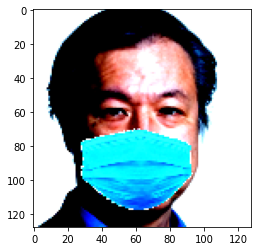

In [ ]:
img = train_dataset[5][0]
image = torch.permute(img, (1,2,0))
#diff = tensor.amax(img, 2)
plt.imshow(image)

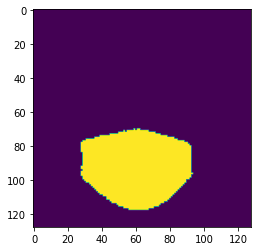

In [ ]:
img = train_dataset[5][1]
image = torch.permute(img, (1,2,0))
image = image.squeeze()
#diff = tensor.amax(img, 2)
plt.imshow(image)

In [ ]:
max_score = 0

for i in range(0, 3):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(dataloader_train)
    valid_logs = valid_epoch.run(dataloader_valid)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')



Epoch: 0
train:   0%|          | 0/311 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|██████████| 89/89 [03:04<00:00,  2.07s/it, dice_loss - 0.02343, iou_score - 0.966]
Model saved!

Epoch: 1
valid: 100%|██████████| 89/89 [02:58<00:00,  2.00s/it, dice_loss - 0.01614, iou_score - 0.9744]
Model saved!

Epoch: 2
valid: 100%|██████████| 89/89 [02:58<00:00,  2.01s/it, dice_loss - 0.01436, iou_score - 0.9759]
Model saved!


In [ ]:
best_model = torch.load('./best_model.pth')
best_model2 = torch.load('./best_model2.pth')

FileNotFoundError: ignored

In [ ]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
for i in range(10,20):
  image, gt_mask = test_dataset[i]

  gt_mask = gt_mask.squeeze()

  x_tensor = image.unsqueeze(0)
  pr_mask = best_model.predict(x_tensor)
  pr_mask = (pr_mask.squeeze().numpy().round())
  image = torch.permute(image, (1,2,0))
  visualize(
    mask_prediction=pr_mask, 
    mask_label=gt_mask,
    actual_image = image)

NameError: ignored

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
)

logs = test_epoch.run(dataloader_test)

valid:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|██████████| 45/45 [00:29<00:00,  1.55it/s, dice_loss - 0.008091, iou_score - 0.986]


In [ ]:
logs2

NameError: ignored

In [ ]:
logs

{'dice_loss': 0.008159763283199735, 'iou_score': 0.9858386715253196}